In [1]:
%cd ~/user_data/research/samclip
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/samclip


/home/DREXEL/jw3897/miniconda3/envs/samclip_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/DREXEL/jw3897/miniconda3/envs/samclip_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/samclip'

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import cv2
from pycocotools.coco import COCO

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
def show_bboxes(anns):
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    for ann in anns:
        # From SAM, bboxes are [x, y, w, h]
        bbox = patches.Rectangle(
            (ann['bbox'][0], ann['bbox'][1]), ann['bbox'][2], ann['bbox'][3],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
            )
        
        ax.add_patch(bbox)
        

In [6]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
val_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/instances_val2017.json'

coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=val_annotation_path,
)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [23]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = r'/mnt/active_storage/Joe/sam_checkpoints/sam_vit_h_4b8939.pth'
model_type = r'vit_h'

device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    stability_score_offset=1.0,
    box_nms_thresh=0.1,
    crop_n_layers=0,
    crop_nms_thresh=0.2,
    crop_overlap_ratio=(512/1500),
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=0,
    output_mode="binary_mask",
    )

Threshold: 0.1


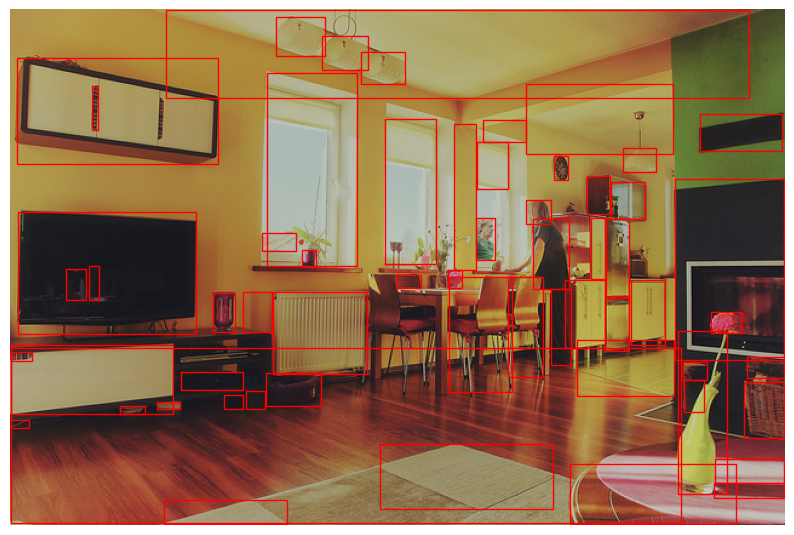

Threshold: 0.2


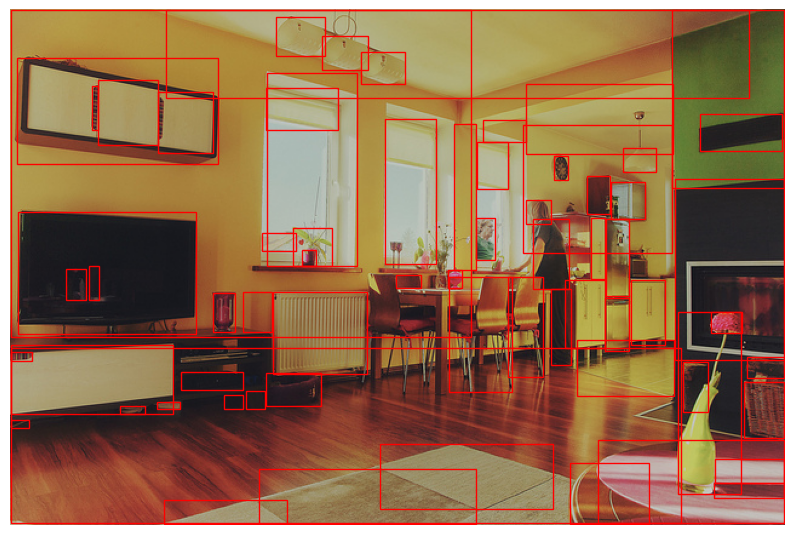

Threshold: 0.3


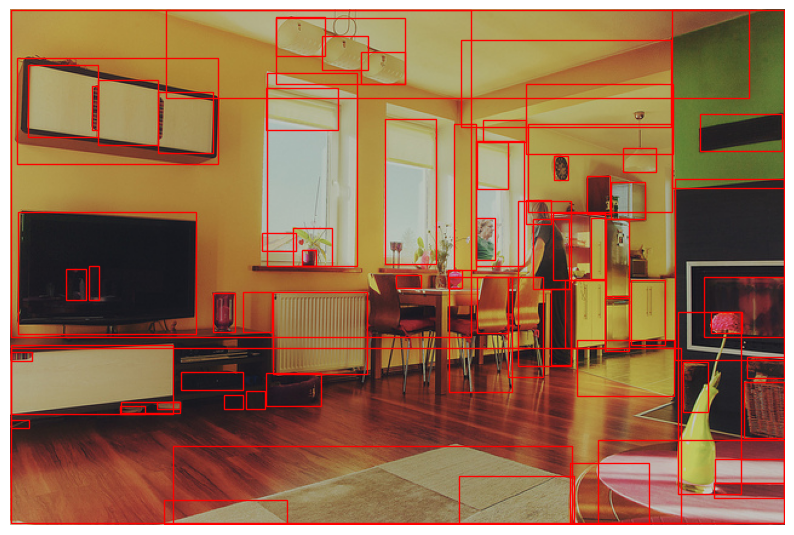

Threshold: 0.4


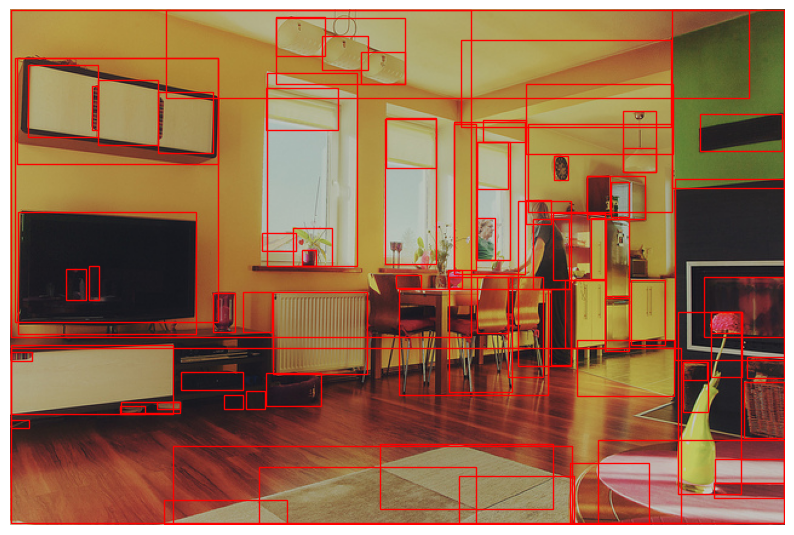

Threshold: 0.5


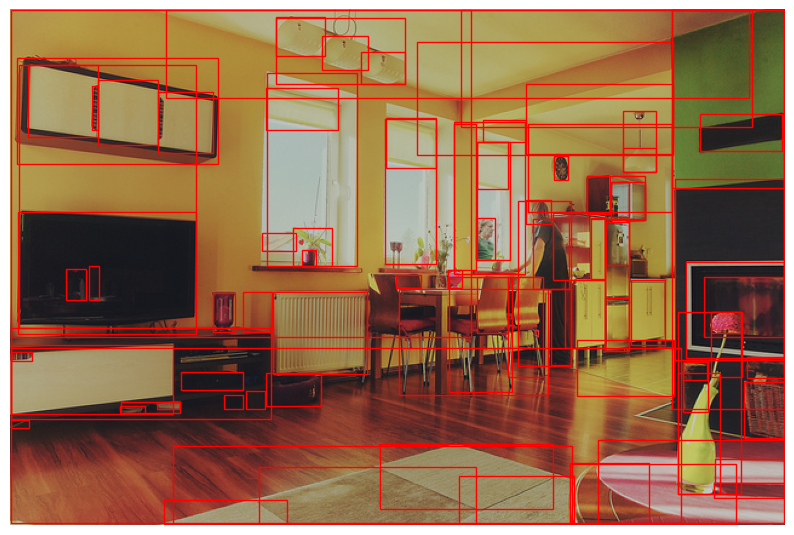

Threshold: 0.6


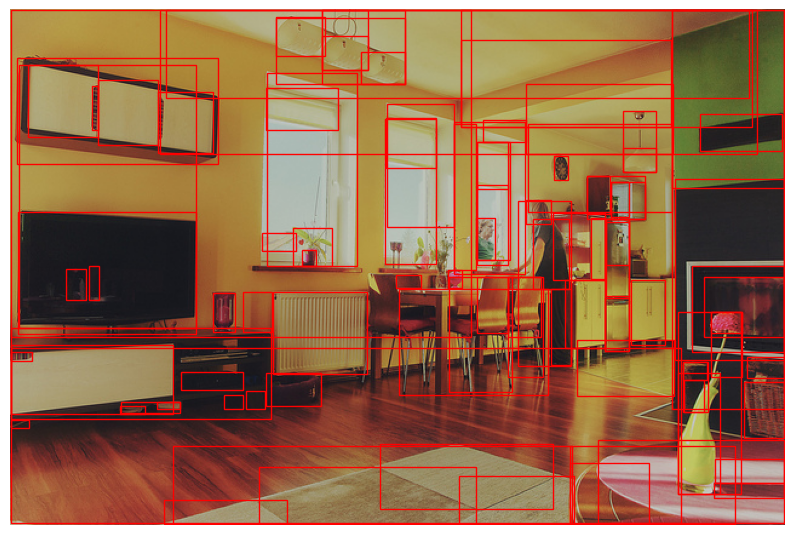

Threshold: 0.7


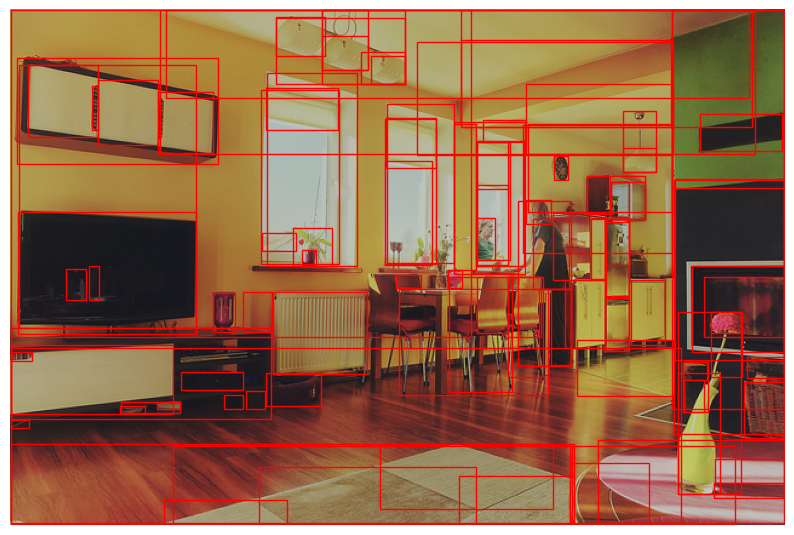

Threshold: 0.8


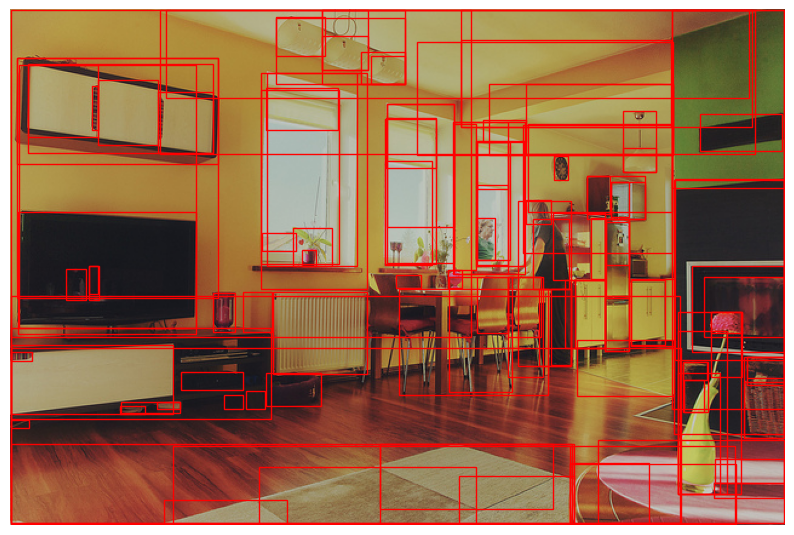

Threshold: 0.9


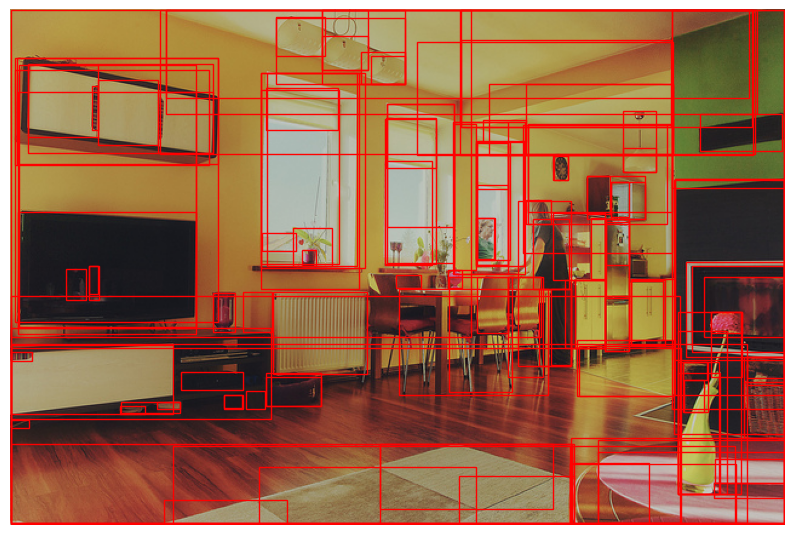

In [30]:
for thresh in range(1, 10, 1):
    print(f'Threshold: {thresh/10}')
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        points_per_batch=64,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.95,
        stability_score_offset=1.0,
        box_nms_thresh=thresh/10,
        crop_n_layers=0,
        crop_nms_thresh=0.2,
        crop_overlap_ratio=(512/1500),
        crop_n_points_downscale_factor=1,
        point_grids=None,
        min_mask_region_area=0,
        output_mode="binary_mask",
        )
    
    image = np.array(coco_val_dataset[0][0].convert('RGB'))
    masks = mask_generator.generate(image)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_bboxes(masks)
    plt.axis('off')
    plt.show()

    #input()


In [ ]:
def show_bboxes(anns):
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    for ann in anns:
        # From SAM, bboxes are [x, y, w, h]
        bbox = patches.Rectangle(
            (ann['bbox'][0], ann['bbox'][1]), ann['bbox'][2], ann['bbox'][3],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
            )
        
        ax.add_patch(bbox)
        

Ground Truth


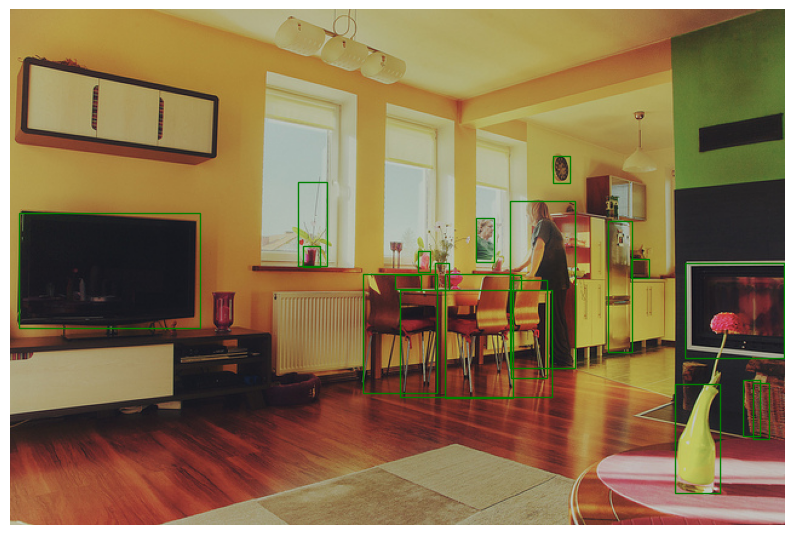

In [39]:
sample = coco_val_dataset[0]
image = np.array(sample[0].convert('RGB'))
bboxes = [annotation['bbox'] for annotation in sample[1]]

print("Ground Truth")
plt.figure(figsize=(10, 10))
plt.imshow(image)

ax = plt.gca()
ax.set_autoscale_on(False)

for bbox in bboxes:
    patch = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=1,
        edgecolor='g',
        facecolor='none'
    )

    ax.add_patch(patch)

plt.axis('off')
plt.show()

In [ ]:
for idx, item in enumerate(coco_val_dataset):
    image = np.array(item[0].convert('RGB'))
    masks = mask_generator.generate(image)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_bboxes(masks)
    plt.axis('off')
    plt.show()

    input()

In [ ]:
# def custom_collate(batch):
#     max_height = 0
#     max_width = 0
#     for item in batch:
#         image = item[0]
#         #print(image.size)
#         #print(image.shape[1])
#         #print()
#         if image.shape[1] > max_height: max_height = image.shape[1]
#         if image.shape[2] > max_width: max_width = image.shape[2]

#     resized_batch = []
#     for item in batch:
#         image = item[0]
#         # As a separate experiment, it might be better to pad instead of resize
#         resized_batch.append(torchvision.transforms.Resize((max_height, max_width))(image))

#     output_images = torch.stack(resized_batch, dim=0)
            

#     # print('Batch:')
#     # print(batch)
#     # resized_batch = torchvision.transforms.Resize((max_height, max_width))(torch.Tensor(batch))
#     # print(f"Resized batch: {type(resized_batch)}")

#     return output_images, [item[1] for item in batch]

In [8]:
dataloader = DataLoader(coco_val_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

In [ ]:
for idx, batch in enumerate(dataloader):
    print(batch)
    input()

In [166]:
sample = next(iter(dataloader))

In [ ]:
img = sample[0]
plt.imshow(torchvision.transforms.functional.to_pil_image(img))
plt.show()

In [ ]:
print(coco_val_dataset[0])

In [ ]:
coco_ann_file = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/instances_val2017.json'
coco = COCO(coco_ann_file)

In [8]:
#category_ids = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
#image_ids = coco.getImgIds(catIds=category_ids)
image_ids = coco.getImgIds(imgIds=[324158])
image_meta = coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

In [9]:
image = Image.open(rf'/mnt/active_storage/Joe/coco_set/val2017/images/{image_meta["file_name"]}')
image = np.array(image.convert('RGB'))

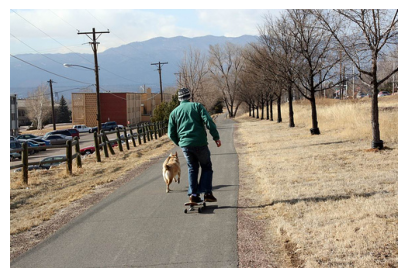

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = r'/mnt/active_storage/Joe/sam_checkpoints/sam_vit_h_4b8939.pth'
model_type = r'vit_h'

device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
masks = mask_generator.generate(image)

In [ ]:
# def get_bboxes_tensor(anns):
#     bboxes = [ann['bbox'] for ann in anns]
#     bboxes = torch.tensor(bboxes)
#     print(bboxes)
        
# bboxes = get_bboxes_tensor(masks)
# torchvision.ops.nms(bboxes, )

tensor([[  0,   0, 352,  68],
        [  0, 140, 293, 192],
        [204, 102,  67, 149],
        [  0,   0, 352, 102],
        [  0, 110,  10,  53],
        [203, 117,  66,  60],
        [  0, 163, 211, 127],
        [289, 111, 210, 221],
        [221, 176,  39,  64],
        [  0, 111, 499, 222],
        [256,  44,  43,  95],
        [394,   0, 105, 179],
        [ 79, 108,  32,  43],
        [357,   0,  66, 161],
        [197, 184,  22,  52],
        [250, 237,  16,  11],
        [181, 111,  37,  34],
        [  0, 185, 200, 140],
        [150, 108,  18,  41],
        [118, 145,  20,  11],
        [ 61, 111,  16,  35],
        [216,  50,  38,  67],
        [386, 153,  13,   8],
        [ 79, 108,  89,  43],
        [ 15, 171,   8,  55],
        [  3, 172,  20,  53],
        [116, 108,  52,  42],
        [216, 101,  17,  17],
        [466, 169,  14,  11],
        [257, 118,  17,  17],
        [ 82, 164,  10,  40],
        [ 80, 149,  24,   9],
        [291, 120,  15,  17],
        [2

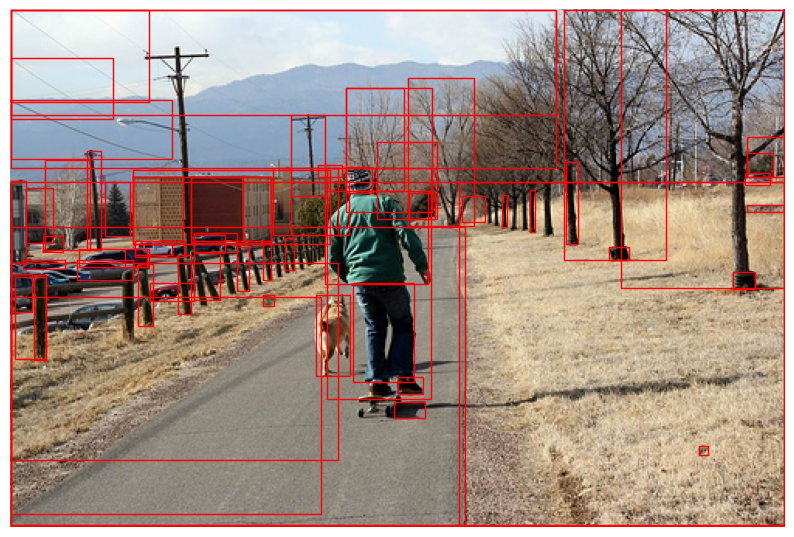

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_bboxes(masks)
plt.axis('off')
plt.show()

In [ ]:
# {
#     crop_id
#     crop_image
#     crop_coordinates
#     crop_category
#     category_score
# }

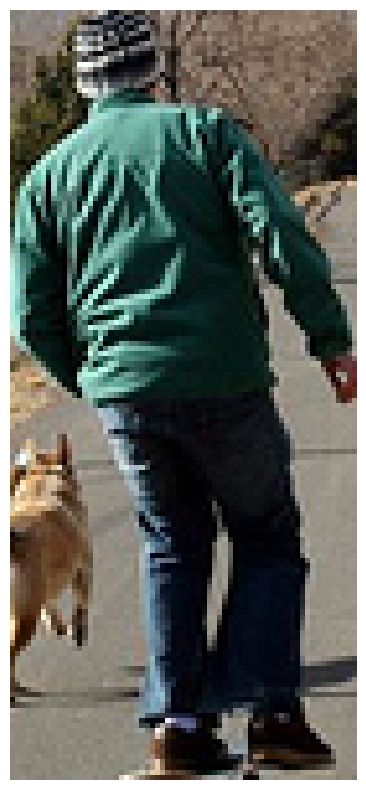

In [23]:
#image = Image.fromarray(image)
crop_id = 2
crop = Image.fromarray(image).crop((masks[crop_id]['bbox'][0], 
                   masks[crop_id]['bbox'][1],
                   masks[crop_id]['bbox'][0] + masks[crop_id]['bbox'][2],
                   masks[crop_id]['bbox'][1] + masks[crop_id]['bbox'][3],
                   ))

plt.figure(figsize=(10, 10))
plt.imshow(np.array(crop.convert('RGB')))
plt.axis('off')
plt.show()

In [27]:
import clip

clip_image = Image.open(rf'/mnt/active_storage/Joe/coco_set/val2017/images/{image_meta["file_name"]}')
model, preprocess = clip.load('ViT-B/32', device=device)

clip_image = preprocess(crop).unsqueeze(0).to(device)
all_categories = [category['name'] for category in coco.dataset['categories']]
text = clip.tokenize(all_categories).to(device)

with torch.no_grad():
    image_features = model.encode_image(clip_image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(clip_image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print('label probs:', probs[0])

max_label_index = np.argmax(probs[0])
top_category = all_categories[max_label_index]
top_category_score = probs[0][max_label_index]

label probs: [9.9548e-02 3.1986e-03 7.9632e-04 1.2922e-03 1.7226e-04 1.4877e-03
 1.0223e-03 1.0223e-03 4.6086e-04 4.3068e-03 1.2077e-02 2.0657e-03
 9.7046e-03 1.3332e-03 4.8027e-03 4.9255e-02 3.5278e-01 1.3054e-02
 1.2077e-02 1.0826e-02 1.5593e-03 2.5970e-02 1.0071e-03 2.2678e-03
 1.0760e-01 1.5593e-03 1.2260e-02 1.4648e-03 7.0992e-03 2.5970e-02
 2.0332e-03 1.4648e-03 1.3981e-03 4.1733e-03 3.5133e-03 4.8790e-03
 5.1636e-02 2.0027e-03 2.3785e-03 9.7561e-04 3.5334e-04 2.1305e-03
 4.6539e-03 3.9825e-03 1.8520e-03 4.9553e-03 2.8229e-03 3.4599e-03
 1.0826e-02 7.4387e-03 3.1490e-03 1.2077e-02 3.5492e-02 1.2922e-03
 1.8806e-03 1.0071e-03 1.6336e-03 5.3883e-04 4.9829e-04 1.5926e-04
 2.5058e-04 5.7364e-04 6.7043e-04 8.3447e-04 8.1711e-03 5.2757e-03
 9.4557e-04 2.0538e-02 7.4816e-04 1.5593e-03 1.9102e-03 1.8048e-04
 6.6042e-04 8.3447e-04 4.3988e-04 3.4785e-04 1.5116e-03 8.8348e-03
 1.6336e-03 1.3332e-03]


In [28]:
print(top_category)
print(top_category_score)

dog
0.3528


In [ ]:
# 1. Use SAM to get bounding boxes (we can mess around with objectness score)
# 2. CLIP goes over every bounding boxes used categories. Repo categories maybe? (for eval we can use COCO)
# 3. Use CLIP scores for filtering known vs. unknown